In [1]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 

import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)


from src.model_estimations.sampler_mh_conjugate_variance import *
from src.analize_chain_convergence import * 
from src.analize_mcmc import * 
from src.plot_posterior_densitys import * 
from src.posterior_predictive_check import *

In [2]:
variables = pd.read_csv(r'../data\df_clean.csv')
variables

,Unnamed: 0,salary,cost,LSAT,GPA,age,llibvol,lcost,rank
0,0,31400.0,8340.0,155.0,3.15,12.0,5.375278,9.028818,128
1,1,33098.0,6980.0,160.0,3.50,113.0,5.545177,8.850804,104
2,2,32870.0,16370.0,155.0,3.25,134.0,6.049734,9.703206,34
3,3,35000.0,17566.0,157.0,3.20,89.0,5.796058,9.773721,49
4,4,33606.0,8350.0,162.0,3.38,70.0,5.805135,9.030017,95
...,...,...,...,...,...,...,...,...,...
151,151,49321.0,13530.0,162.0,3.34,206.0,5.703783,9.512665,17
152,152,49900.0,11334.0,161.0,3.40,117.8,5.985650,9.335563,21
153,153,31500.0,7396.0,157.0,3.40,65.0,5.159055,8.908694,143
154,154,69000.0,19780.0,171.0,3.82,140.0,6.745236,9.892426,3


In [3]:
indepent = variables[[ 'cost' , 'LSAT' , 'GPA' ,'age' , 'llibvol' , 'lcost' , 'rank']]
dependet = variables['salary']
indepent

,cost,LSAT,GPA,age,llibvol,lcost,rank
0,8340.0,155.0,3.15,12.0,5.375278,9.028818,128
1,6980.0,160.0,3.50,113.0,5.545177,8.850804,104
2,16370.0,155.0,3.25,134.0,6.049734,9.703206,34
3,17566.0,157.0,3.20,89.0,5.796058,9.773721,49
4,8350.0,162.0,3.38,70.0,5.805135,9.030017,95
...,...,...,...,...,...,...,...
151,13530.0,162.0,3.34,206.0,5.703783,9.512665,17
152,11334.0,161.0,3.40,117.8,5.985650,9.335563,21
153,7396.0,157.0,3.40,65.0,5.159055,8.908694,143
154,19780.0,171.0,3.82,140.0,6.745236,9.892426,3


In [4]:
X = indepent.to_numpy()
y = dependet.to_numpy()

print(X.shape , y.shape)

(156, 7) (156,)


In [5]:
np.log(y)

array([10.35456317, 10.40722814, 10.40031567, 10.46310334, 10.4224599 ,
       10.36407196, 10.32252678, 10.3139402 , 10.35137338, 10.41030515,
       10.46024211, 10.9225695 , 10.4267357 , 11.08214255, 10.71752405,
       11.03488966, 11.05089001, 10.35137338, 10.25765937, 10.31228045,
       10.42376834, 10.6047269 , 11.15625052, 10.39818379, 10.26234312,
       10.46310334, 11.26862212, 10.49432511, 11.11988288, 10.3609124 ,
       10.30226367, 10.27159687, 10.65254237, 10.40122794, 10.28192399,
       10.4487146 , 10.4036566 , 10.38282251, 11.00496241, 10.37639322,
       10.7386333 , 10.84427576, 10.43117029, 11.08029469, 10.28657071,
       10.25629001, 11.01862914, 11.04619647, 10.73398072, 10.31261262,
       10.43793204, 10.44581184, 11.12453869, 10.32810148, 10.84118746,
       10.57131693, 10.29214554, 10.20359214, 10.59663473, 10.81977828,
       10.34174248, 10.16585182, 11.05089001, 10.30895266, 10.49127422,
       10.40426284, 10.30058441, 10.45593485, 10.43117029, 10.46

In [18]:
# --- Design matrix ---
X0 = X.copy()
muX = X0.mean(axis=0)
sdX = X0.std(axis=0, ddof=1)
sdX[sdX == 0] = 1.0

X_std = (X0 - muX) / sdX
X_design = np.hstack([np.ones((len(y), 1)), X_std])

# --- sigma^2 prior calibrado a log(y) ---
y_log = np.log(y)
s2_emp = y_log.var(ddof=1)

a0 = 3.0
b0 = (a0 - 1) * s2_emp    # prior mean ~ s2_emp

# --- MCMC settings ---
n_draws = 50_000
burn_in = 10_000
thinning = 1
seed = 42

prior = "laplace"
prior_kwargs = {"b": 50.0}

beta_post, sigma_post, acc, info = MCMC_LM_beta_nonconj_sigma_conj(
    X_design, y_log,
    a0=a0, b0=b0,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,
    prior=prior,
    prior_kwargs=prior_kwargs,

    sigma2_init=s2_emp,
    proposal_scale=0.2,
    adapt=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    progress=True,
    progress_every=1000,
    return_info=True,
    adapt_gain=2.0
)

print("beta_post:", beta_post.shape)
print("sigma_post:", sigma_post.shape)
print("acceptance rate:", acc)


[   1000/50000] acc_total=0.295 sigma2=0.01057 prop_scale=2.27 | 8,681.7 it/s | block=0.12s | ETA≈0.1 min
[   2000/50000] acc_total=0.203 sigma2=0.01265 prop_scale=0.981 | 10,577.9 it/s | block=0.09s | ETA≈0.1 min
[   3000/50000] acc_total=0.213 sigma2=0.0162 prop_scale=0.906 | 9,678.5 it/s | block=0.10s | ETA≈0.1 min
[   4000/50000] acc_total=0.226 sigma2=0.01112 prop_scale=0.951 | 8,943.3 it/s | block=0.11s | ETA≈0.1 min
[   5000/50000] acc_total=0.230 sigma2=0.01797 prop_scale=0.941 | 9,308.8 it/s | block=0.11s | ETA≈0.1 min
[   6000/50000] acc_total=0.232 sigma2=0.0116 prop_scale=0.929 | 9,007.8 it/s | block=0.11s | ETA≈0.1 min
[   7000/50000] acc_total=0.235 sigma2=0.01112 prop_scale=0.936 | 9,068.1 it/s | block=0.11s | ETA≈0.1 min
[   8000/50000] acc_total=0.236 sigma2=0.01296 prop_scale=0.927 | 8,458.2 it/s | block=0.12s | ETA≈0.1 min
[   9000/50000] acc_total=0.239 sigma2=0.01362 prop_scale=0.95 | 9,546.0 it/s | block=0.10s | ETA≈0.1 min
[  10000/50000] acc_total=0.239 sigma2=0

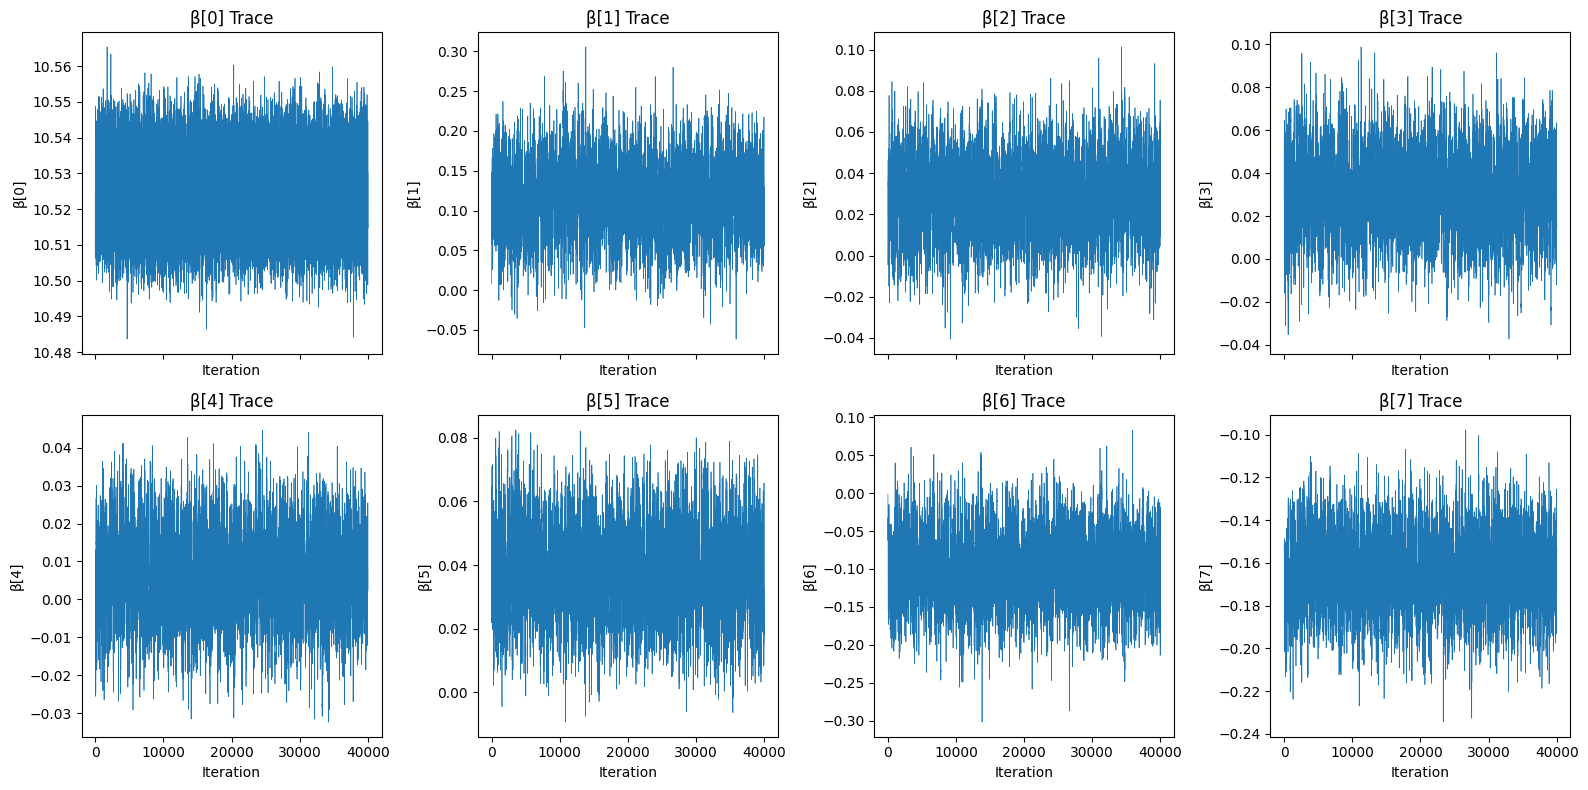

In [19]:
fig = plot_beta_traces(beta_post, ncols=4, figsize=(16, 8))

In [20]:
rep = mcmc_efficiency_report(
    beta_post,
    param_prefix="β",
    max_lag=200,  
    rank_by="ess",
    top_k=8)

display(rep["table"])  
display(rep["worst"])  

,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[0],1,40000,1.000000,1.000000,40000.000000,40000.000000,1.000000,0.0
β[1],1,40000,23.284877,23.284877,1717.853174,1717.853174,0.042946,74.0
β[2],1,40000,20.623738,20.623738,1939.512614,1939.512614,0.048488,38.0
β[3],1,40000,22.065884,22.065884,1812.753126,1812.753126,0.045319,44.0
β[4],1,40000,23.123338,23.123338,1729.854091,1729.854091,0.043246,74.0
β[5],1,40000,24.436416,24.436416,1636.901235,1636.901235,0.040923,116.0
β[6],1,40000,22.492984,22.492984,1778.332337,1778.332337,0.044458,74.0
β[7],1,40000,22.209615,22.209615,1801.021758,1801.021758,0.045026,48.0


,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[5],1,40000,24.436416,24.436416,1636.901235,1636.901235,0.040923,116.0
β[1],1,40000,23.284877,23.284877,1717.853174,1717.853174,0.042946,74.0
β[4],1,40000,23.123338,23.123338,1729.854091,1729.854091,0.043246,74.0
β[6],1,40000,22.492984,22.492984,1778.332337,1778.332337,0.044458,74.0
β[7],1,40000,22.209615,22.209615,1801.021758,1801.021758,0.045026,48.0
β[3],1,40000,22.065884,22.065884,1812.753126,1812.753126,0.045319,44.0
β[2],1,40000,20.623738,20.623738,1939.512614,1939.512614,0.048488,38.0
β[0],1,40000,1.000000,1.000000,40000.000000,40000.000000,1.000000,0.0


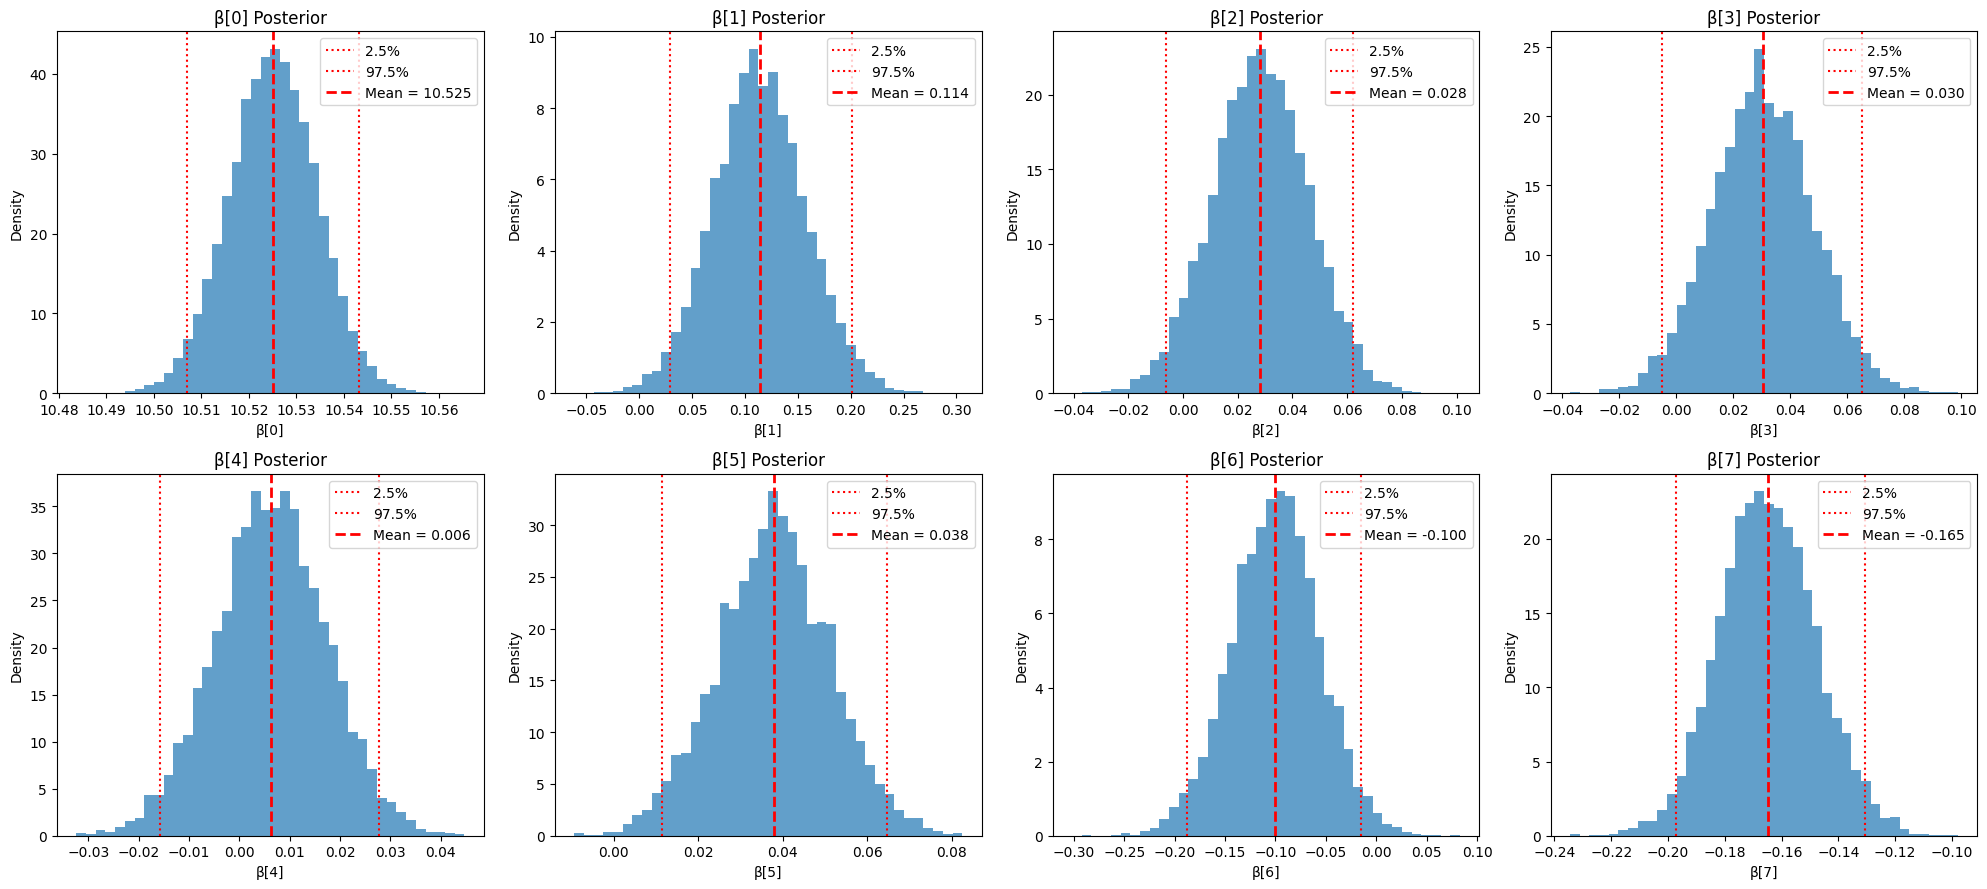

In [21]:
fig = plot_beta_posteriors(beta_post, ncols=4, figsize=(20, 9))

In [22]:
df = summarize_beta_posterior(
    beta_post,
    ci=0.95,
    tests=[{"name":"P(>0)", "fn": lambda s: s > 0}]
)
display(df)

,mean,median,sd,2%,97%,P(>0)
parameter,,,,,,
β[0],10.525100,10.525145,0.009245,10.506938,10.543215,1.000000
β[1],0.114067,0.113001,0.043707,0.029550,0.201390,0.996250
β[2],0.028268,0.028285,0.017484,-0.006118,0.062298,0.946050
β[3],0.030343,0.030091,0.017869,-0.004949,0.065289,0.956575
β[4],0.006270,0.006338,0.011034,-0.015699,0.027634,0.719100
β[5],0.037915,0.037947,0.013379,0.011325,0.064580,0.998375
β[6],-0.100077,-0.099249,0.043606,-0.187958,-0.014712,0.009975
β[7],-0.164735,-0.165152,0.017053,-0.197305,-0.130553,0.000000


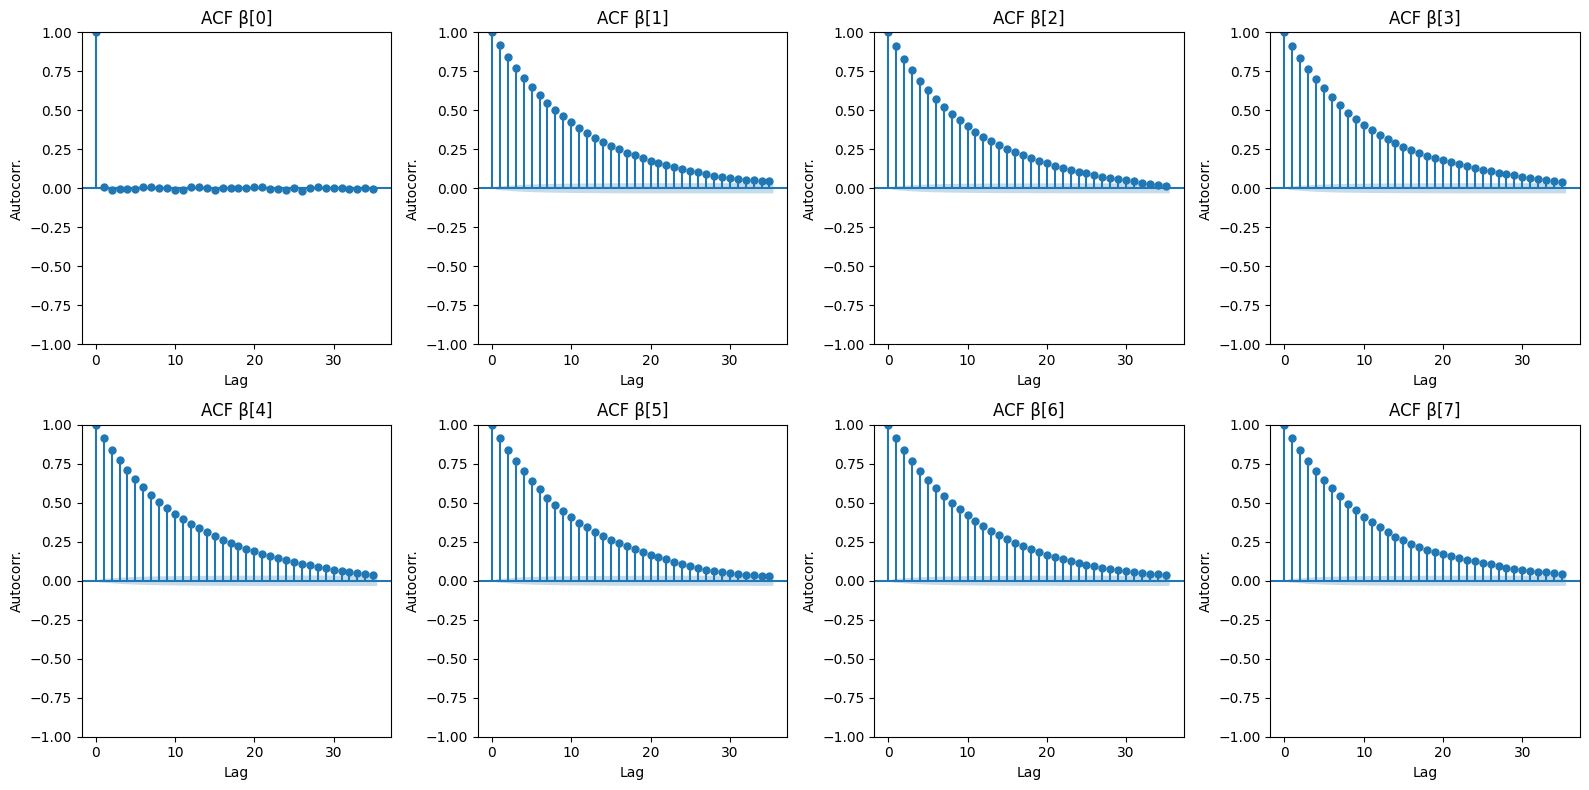

In [23]:
fig = plot_beta_acf(beta_post, lags=35, alpha=0.05, ncols=4, figsize=(16, 8))

--- 

# Arviz Analisis 

In [ ]:
beta2, sigma2, acc2, info2 = MCMC_LM_beta_nonconj_sigma_conj(
    X_design, y_log,
    a0=a0, b0=b0,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,
    prior=prior,
    prior_kwargs=prior_kwargs,

    sigma2_init=s2_emp,
    proposal_scale=0.2,
    adapt=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    progress=False,
    progress_every=1000,
    return_info=True,
    adapt_gain=2.0)


idata = build_idata_from_chains(
    beta_chains=[beta_post, beta2],
    sigma2_chains=[sigma_post, sigma2],
    coef_names=[f"beta_{j}" for j in range(beta_post.shape[1])])

rep = arviz_mcmc_report(
    idata,
    var_names=("beta", "sigma2"),
    hdi_prob=0.95,
    rhat_warn=1.01,
    ess_bulk_warn=400,
    mcse_rel_warn=0.10,)

print(rep["text"])
display(rep["summary"])  

=== MCMC Diagnostics Report (ArviZ) ===
Chains: 2 | Draws per chain: 40000 | Total draws: 80000
HDI prob: 0.95
No red flags under chosen thresholds.
Worst-case diagnostics:
  - worst_rhat: 1.0006
  - worst_rhat_param: beta[beta_6]
  - min_ess_bulk: 3345.7073
  - min_ess_bulk_param: beta[beta_5]
  - min_ess_tail: 4965.7603
  - min_ess_tail_param: beta[beta_5]
  - max_mcse_rel: 0.031746031746031744
  - max_mcse_rel_param: beta[beta_4]


c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:142: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_chains = idata.posterior.dims.get("chain", None)
c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:143: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = idata.posterior.dims.get("draw", None)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mcse_rel
beta[beta_0],10.5251,0.0092,10.5065,10.5427,0.0000,0.0000,79188.6533,78960.7145,1.0000,0.000000
beta[beta_1],0.1141,0.0437,0.0293,0.2004,0.0007,0.0004,3438.3786,5071.1784,1.0005,0.006135
beta[beta_2],0.0283,0.0175,-0.0055,0.0626,0.0003,0.0002,3876.8044,6007.4148,1.0001,0.010601
beta[beta_3],0.0303,0.0179,-0.0051,0.0652,0.0003,0.0002,3630.1070,5770.0463,1.0000,0.009901
beta[beta_4],0.0063,0.0110,-0.0152,0.0279,0.0002,0.0001,3525.3579,5762.4911,1.0001,0.031746
beta[beta_5],0.0379,0.0134,0.0128,0.0657,0.0002,0.0001,3345.7073,4965.7603,1.0001,0.005277
beta[beta_6],-0.1001,0.0436,-0.1880,-0.0151,0.0007,0.0004,3566.6402,5226.1909,1.0006,0.006993
beta[beta_7],-0.1647,0.0171,-0.1960,-0.1294,0.0003,0.0002,3615.5479,5774.0437,1.0000,0.001821
sigma2,0.0132,0.0015,0.0104,0.0162,0.0000,0.0000,35807.0115,62507.9871,1.0000,0.000000


In [26]:
idata_ppc = attach_posterior_predictive_y(idata, X_design, seed=123, var_name="y")

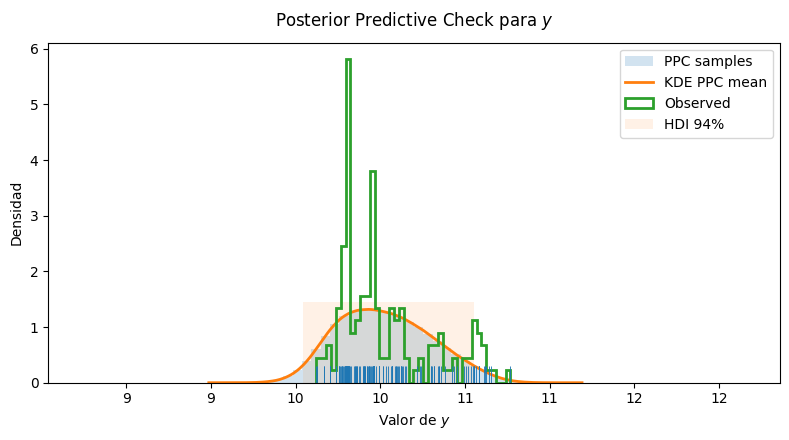

(<Figure size 800x450 with 1 Axes>,
 <Axes: title={'center': 'Posterior Predictive Check para $y$'}, xlabel='Valor de $y$', ylabel='Densidad'>)

In [27]:

plot_ppc_density_y(
    idata=idata_ppc,   
    y=y,
    obs_transform=np.log,
    var_name="y",
    hdi_prob=0.94,
    bins=40)

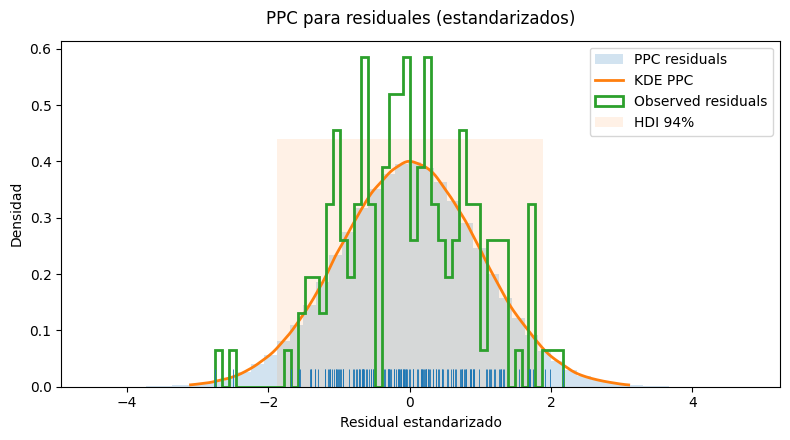

In [28]:
out = plot_ppc_residuals(
    idata=idata_ppc, 
    X=X_design,
    y=y,
    y_transform=np.log,
    standardize=True,
    use_posterior_predictive=True, 
    subsample_draws=3000,
    hdi_prob=0.94,)

--- 

In [30]:
from src.model_estimations.sampler_adaptmh_conjugate_variance import * 

# --- Design matrix ---
X0 = X.copy()
muX = X0.mean(axis=0)
sdX = X0.std(axis=0, ddof=1)
sdX[sdX == 0] = 1.0

X_std = (X0 - muX) / sdX
X_design = np.hstack([np.ones((len(y), 1)), X_std])

# --- sigma^2 prior calibrado a log(y) ---
y_log = np.log(y)
s2_emp = y_log.var(ddof=1)

a0 = 3.0
b0 = (a0 - 1) * s2_emp    # prior mean ~ s2_emp

# --- MCMC settings ---
n_draws = 50_000
burn_in = 10_000
thinning = 1
seed = 42

prior = "laplace"
prior_kwargs = {"b": 50.0}

beta_post, sigma_post, acc, info = MCMC_LM_beta_nonconj_sigma_conj_adaptcov_slopes(
    X_design, y_log,
    a0=a0, b0=b0,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,

    prior=prior,
    prior_kwargs=prior_kwargs,

    sigma2_init=s2_emp,

    proposal_scale=0.2,

    adapt_scale=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    adapt_gain=2.0,
    adapt_max_scale=10.0,
    adapt_min_scale=1e-6,

    # --- adaptive covariance for slopes (burn-in only) ---
    adapt_cov=True,
    cov_start="xtx",         # good default
    cov_start_at=500,        # start learning empirical cov after 500 iters
    cov_update_every=200,    # refresh chol every 200 iters
    cov_ridge=1e-6,          # jitter for PD safety

    intercept_idx=0,

    progress=True,
    progress_every=1000,
    return_info=True,)

print("beta_post:", beta_post.shape)
print("sigma_post:", sigma_post.shape)
print("acceptance rate (slopes MH):", acc)
print("final proposal scale:", info["final_proposal_scale"])

[   1000/50000] acc_total=0.364 sigma2=0.01126 prop_scale=4.17 | 5,964.2 it/s | block=0.17s | ETA≈0.1 min
[   2000/50000] acc_total=0.312 sigma2=0.01584 prop_scale=4.4 | 4,949.6 it/s | block=0.20s | ETA≈0.2 min
[   3000/50000] acc_total=0.299 sigma2=0.014 prop_scale=4.84 | 6,140.0 it/s | block=0.16s | ETA≈0.1 min
[   4000/50000] acc_total=0.293 sigma2=0.01414 prop_scale=5.3 | 7,038.9 it/s | block=0.14s | ETA≈0.1 min
[   5000/50000] acc_total=0.284 sigma2=0.01317 prop_scale=5.28 | 7,143.3 it/s | block=0.14s | ETA≈0.1 min
[   6000/50000] acc_total=0.285 sigma2=0.01293 prop_scale=5.88 | 6,522.1 it/s | block=0.15s | ETA≈0.1 min
[   7000/50000] acc_total=0.283 sigma2=0.01241 prop_scale=6.23 | 6,981.8 it/s | block=0.14s | ETA≈0.1 min
[   8000/50000] acc_total=0.279 sigma2=0.01117 prop_scale=6.29 | 7,777.0 it/s | block=0.13s | ETA≈0.1 min
[   9000/50000] acc_total=0.277 sigma2=0.01567 prop_scale=6.36 | 8,443.1 it/s | block=0.12s | ETA≈0.1 min
[  10000/50000] acc_total=0.275 sigma2=0.01254 pro

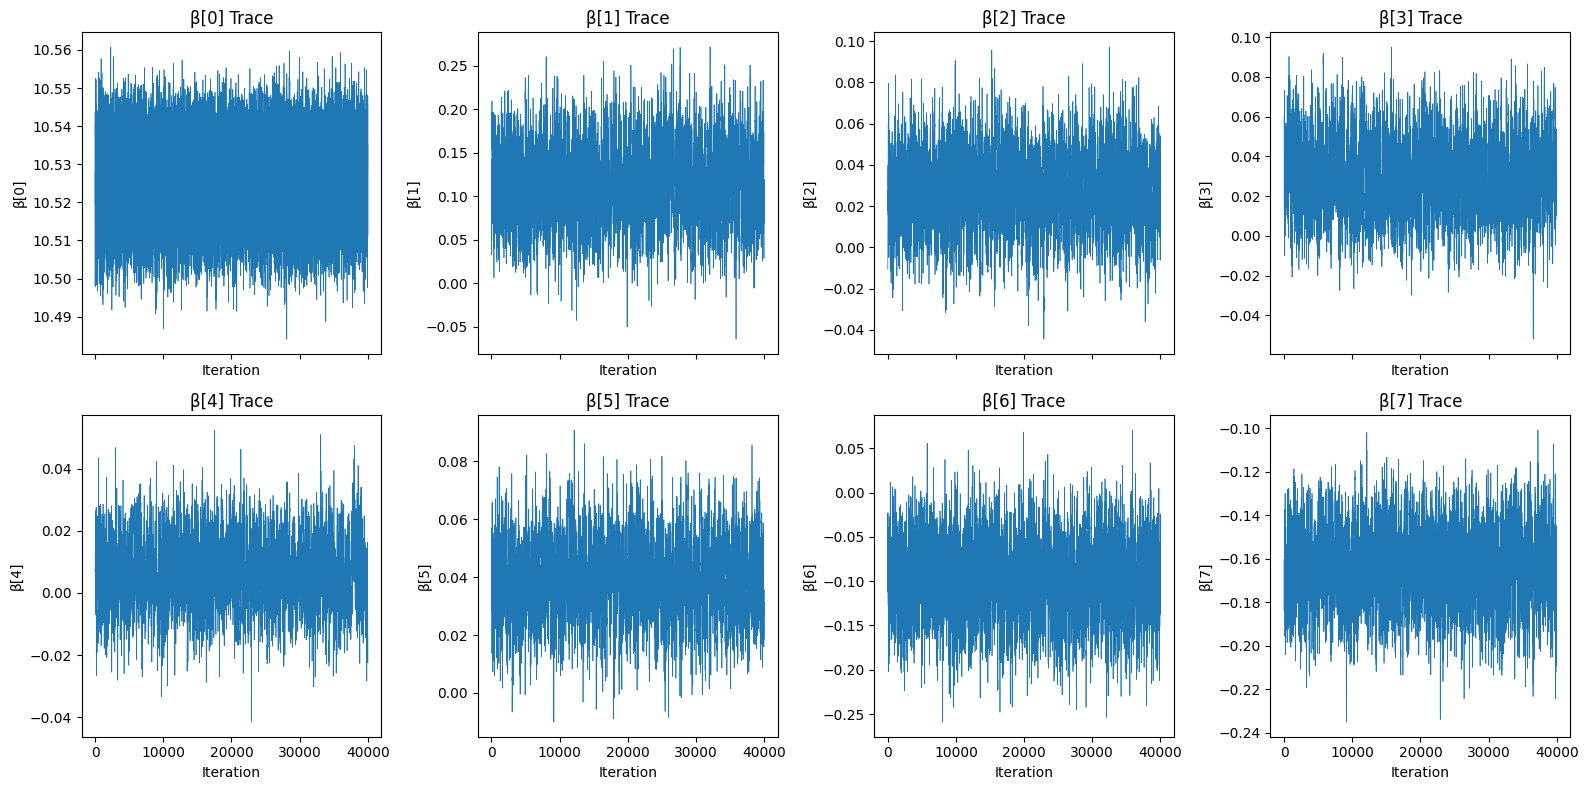

In [31]:
fig = plot_beta_traces(beta_post, ncols=4, figsize=(16, 8))

In [32]:
rep = mcmc_efficiency_report(
    beta_post,
    param_prefix="β",
    max_lag=200,  
    rank_by="ess",
    top_k=8)

display(rep["table"])  
display(rep["worst"])  

,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[0],1,40000,1.045460,1.045460,38260.682218,38260.682218,0.956517,6.0
β[1],1,40000,26.597400,26.597400,1503.906401,1503.906401,0.037598,54.0
β[2],1,40000,31.238322,31.238322,1280.478505,1280.478505,0.032012,110.0
β[3],1,40000,29.136002,29.136002,1372.871940,1372.871940,0.034322,76.0
β[4],1,40000,35.605580,35.605580,1123.419422,1123.419422,0.028085,98.0
β[5],1,40000,32.123456,32.123456,1245.196041,1245.196041,0.031130,92.0
β[6],1,40000,27.027999,27.027999,1479.946781,1479.946781,0.036999,54.0
β[7],1,40000,28.365381,28.365381,1410.169652,1410.169652,0.035254,80.0


,n_chains,n_draws_per_chain,tau_mean,tau_max,ess_mean,ess_min,ess_frac_min,K_used_mean
parameter,,,,,,,,
β[4],1,40000,35.605580,35.605580,1123.419422,1123.419422,0.028085,98.0
β[5],1,40000,32.123456,32.123456,1245.196041,1245.196041,0.031130,92.0
β[2],1,40000,31.238322,31.238322,1280.478505,1280.478505,0.032012,110.0
β[3],1,40000,29.136002,29.136002,1372.871940,1372.871940,0.034322,76.0
β[7],1,40000,28.365381,28.365381,1410.169652,1410.169652,0.035254,80.0
β[6],1,40000,27.027999,27.027999,1479.946781,1479.946781,0.036999,54.0
β[1],1,40000,26.597400,26.597400,1503.906401,1503.906401,0.037598,54.0
β[0],1,40000,1.045460,1.045460,38260.682218,38260.682218,0.956517,6.0


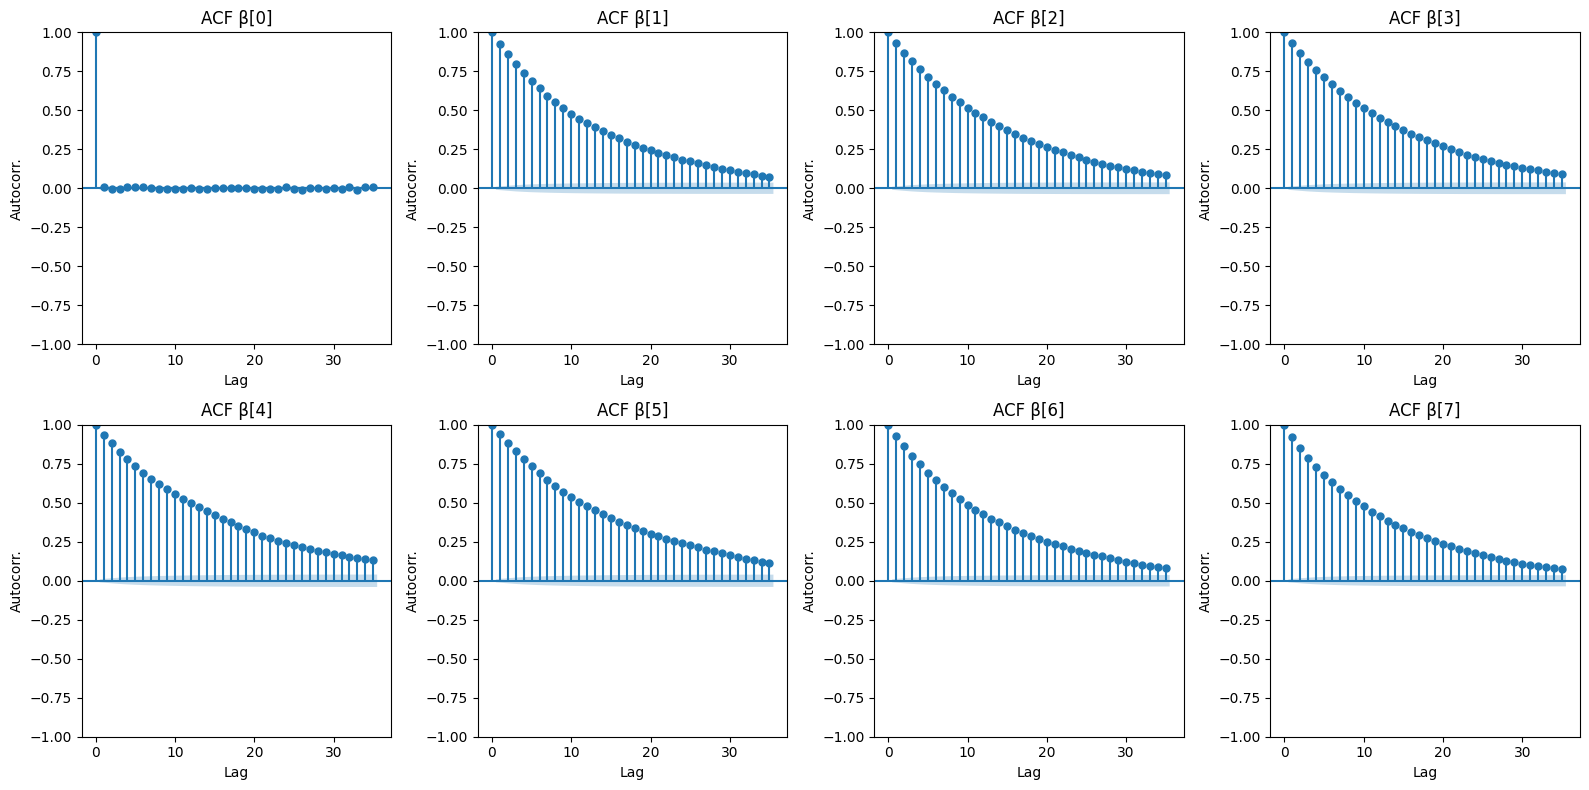

In [37]:
fig = plot_beta_acf(beta_post, lags=35, alpha=0.05, ncols=4, figsize=(16, 8))

In [33]:
beta2, sigma2, acc2, info2 = MCMC_LM_beta_nonconj_sigma_conj_adaptcov_slopes(
    X_design, y_log,
    a0=a0, b0=b0,
    n_draws=n_draws,
    burn_in=burn_in,
    thinning=thinning,
    seed=seed,
    prior=prior,
    prior_kwargs=prior_kwargs,
    sigma2_init=s2_emp,
    proposal_scale=0.2,
    adapt_scale=True,
    target_accept=0.25,
    adapt_every=100,
    adapt_start=400,
    adapt_gain=2.0,
    adapt_max_scale=10.0,
    adapt_min_scale=1e-6,
    adapt_cov=True,
    cov_start="xtx",         
    cov_start_at=500,       
    cov_update_every=200,    
    cov_ridge=1e-6,        
    intercept_idx=0,
    progress=False,
    progress_every=1000,
    return_info=True,)



idata = build_idata_from_chains(
    beta_chains=[beta_post, beta2],
    sigma2_chains=[sigma_post, sigma2],
    coef_names=[f"beta_{j}" for j in range(beta_post.shape[1])])

rep = arviz_mcmc_report(
    idata,
    var_names=("beta", "sigma2"),
    hdi_prob=0.95,
    rhat_warn=1.01,
    ess_bulk_warn=400,
    mcse_rel_warn=0.10,)

print(rep["text"])
display(rep["summary"]) 

=== MCMC Diagnostics Report (ArviZ) ===
Chains: 2 | Draws per chain: 40000 | Total draws: 80000
HDI prob: 0.95
No red flags under chosen thresholds.
Worst-case diagnostics:
  - worst_rhat: 1.0008
  - worst_rhat_param: beta[beta_1]
  - min_ess_bulk: 2250.9557
  - min_ess_bulk_param: beta[beta_4]
  - min_ess_tail: 3871.9555
  - min_ess_tail_param: beta[beta_4]
  - max_mcse_rel: 0.03076923076923077
  - max_mcse_rel_param: beta[beta_4]


c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:142: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_chains = idata.posterior.dims.get("chain", None)
c:\Users\alejo\OneDrive\Escritorio\Profesional\Modelaje\Econometria\bayesian-linear-regression\src\analize_chain_convergence.py:143: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = idata.posterior.dims.get("draw", None)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,mcse_rel
beta[beta_0],10.5251,0.0092,10.5073,10.5434,0.0000,0.0000,78807.3920,79418.8237,1.0001,0.000000
beta[beta_1],0.1155,0.0438,0.0317,0.1999,0.0008,0.0004,3009.6610,5249.1958,1.0008,0.006926
beta[beta_2],0.0277,0.0179,-0.0089,0.0611,0.0004,0.0002,2568.0224,4916.1527,1.0001,0.014440
beta[beta_3],0.0297,0.0179,-0.0055,0.0640,0.0003,0.0002,2751.9521,4866.3252,1.0001,0.010101
beta[beta_4],0.0065,0.0110,-0.0138,0.0287,0.0002,0.0001,2250.9557,3871.9555,1.0001,0.030769
beta[beta_5],0.0388,0.0129,0.0134,0.0636,0.0003,0.0001,2489.6412,4251.0230,1.0006,0.007732
beta[beta_6],-0.1010,0.0440,-0.1862,-0.0170,0.0008,0.0004,2959.9345,5220.4513,1.0006,0.007921
beta[beta_7],-0.1647,0.0169,-0.1978,-0.1315,0.0003,0.0002,2832.8532,4370.5686,1.0003,0.001821
sigma2,0.0132,0.0015,0.0104,0.0163,0.0000,0.0000,35986.4223,68559.2670,1.0000,0.000000


In [38]:
idata_ppc = attach_posterior_predictive_y(idata, X_design, seed=123, var_name="y")

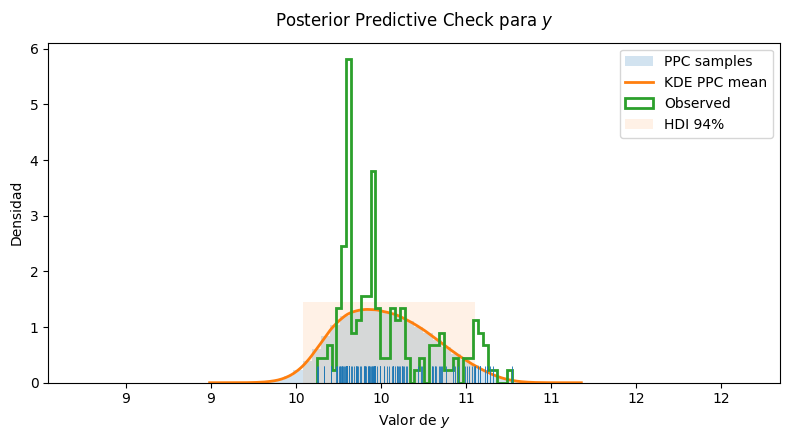

(<Figure size 800x450 with 1 Axes>,
 <Axes: title={'center': 'Posterior Predictive Check para $y$'}, xlabel='Valor de $y$', ylabel='Densidad'>)

In [35]:

plot_ppc_density_y(
    idata=idata_ppc,   
    y=y,
    obs_transform=np.log,
    var_name="y",
    hdi_prob=0.94,
    bins=40)

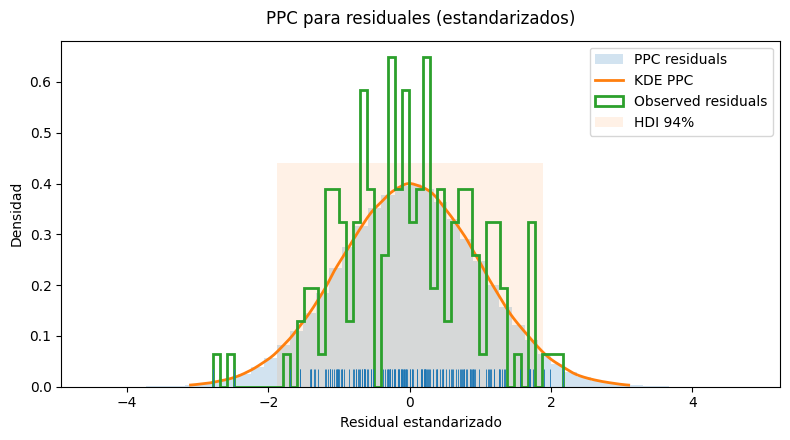

In [36]:
out = plot_ppc_residuals(
    idata=idata_ppc, 
    X=X_design,
    y=y,
    y_transform=np.log,
    standardize=True,
    use_posterior_predictive=True, 
    subsample_draws=3000,
    hdi_prob=0.94,)